## Monte Carlo Policy Gradient - REINFORCE

In [3]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from env_simulator import ToyEnv

In [4]:
env = ToyEnv()

In [8]:
n_states = env.observation_space.shape[0]
n_actions = env.action_space.shape[0]
n_episodes = 2000
gamma = 0.98
max_steps_per_ep = 100
learning_rate = 0.5

In [17]:
class PolicyNetwork():

    def __init__(self, n_states, n_actions):
        self.n_states = n_states
        self.n_actions = n_actions
        self.inputs = tf.placeholder(tf.float32, [None, n_states])
        self.weights = tf.Variable(tf.random_uniform([n_states, n_actions],0,0.01))
        self.outputs = tf.nn.softmax(tf.matmul(self.inputs, self.weights))
        self.targets = tf.placeholder(tf.float32, [None, n_actions])
        self.q_values = tf.placeholder(tf.float32, [None, 1])
        
        self.loss = tf.losses.softmax_cross_entropy(self.targets, self.outputs)
        self.weighted_loss = tf.multiply(self.loss, self.q_values)
        self.optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(self.loss)

    def choose_action(self, s, sess, state_one_hot):
        q = sess.run(self.outputs, feed_dict={self.inputs:state_one_hot[s:s+1]})[0].T
        a = np.random.choice(self.n_actions,1,p=q)
        return a[0]

In [20]:
policy = PolicyNetwork(n_states, n_actions)
init = tf.global_variables_initializer()
state_one_hot = np.eye(n_states)
action_one_hot = np.eye(n_actions)
rewards = [] # To hold total reward per episode
avg_rewards = [] # To hold running average of rewards per episode

with tf.Session() as sess:
    sess.run(init)
    for ep in range(n_episodes):
        s,r,done = env.reset()
        r_list = []
        s_list = []
        n_step = 0
        ep_r = 0
        while not done:
            a = policy.choose_action(s, sess, state_one_hot)
            s_list.append((s,a))
            s,r,done = env.step(a)
            r_list.append(r)
            ep_r += r
            n_step += 1
            if n_step > max_steps_per_ep:
                break
        discounted_r = 0
        for i in range(len(r_list)-1,0,-1):
            discounted_r = gamma*discounted_r + r_list[i]
            target = action_one_hot[s_list[i][1]]
            sess.run(policy.optimizer, 
                     feed_dict={
                        policy.inputs:[state_one_hot[s_list[i][0]]], 
                        policy.targets:[target], 
                        policy.q_values:[[discounted_r]]})
        rewards.append(ep_r)
        avg_rewards.append(sum(rewards[-500:])/500.0)
        if not ep % 100:
            print("Episode #%d : Reward = %f, Avg Rew = %f" % (ep, ep_r, avg_rewards[-1]))    

Episode #0 : Reward = -1.000000, Avg Rew = -0.002000
Episode #100 : Reward = -1.000000, Avg Rew = -0.090000
Episode #200 : Reward = -1.000000, Avg Rew = -0.158000
Episode #300 : Reward = -1.000000, Avg Rew = -0.214000
Episode #400 : Reward = 1.000000, Avg Rew = -0.294000
Episode #500 : Reward = -1.000000, Avg Rew = -0.364000
Episode #600 : Reward = -1.000000, Avg Rew = -0.356000
Episode #700 : Reward = -1.000000, Avg Rew = -0.360000
Episode #800 : Reward = -1.000000, Avg Rew = -0.388000
Episode #900 : Reward = -1.000000, Avg Rew = -0.356000
Episode #1000 : Reward = 1.000000, Avg Rew = -0.352000
Episode #1100 : Reward = -1.000000, Avg Rew = -0.368000
Episode #1200 : Reward = -1.000000, Avg Rew = -0.364000
Episode #1300 : Reward = -1.000000, Avg Rew = -0.380000
Episode #1400 : Reward = 1.000000, Avg Rew = -0.444000
Episode #1500 : Reward = -1.000000, Avg Rew = -0.488000
Episode #1600 : Reward = -1.000000, Avg Rew = -0.500000
Episode #1700 : Reward = -1.000000, Avg Rew = -0.524000
Episode

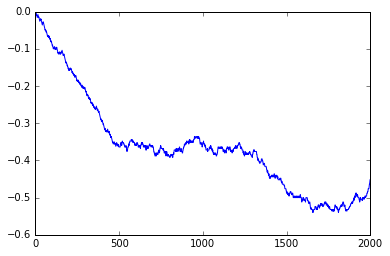

In [21]:
plt.plot(avg_rewards)